### UNET Semantic Segmentation using VGG Encoder

### It expects prediction on 512 x 512 images (This is not specified and wasted a lot of my time).
##### It expects pixel number left to right and then top to bottom. (Row 0, Column 0) is pixel 1, (Row 0, Column 1) is pixel 2....

In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg16_bn,VGG16_BN_Weights
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import os
import PIL
from PIL import Image
from torchvision.transforms import Normalize, ToTensor, Compose
from matplotlib import pyplot as plt
import math
import pandas as pd

In [2]:
if torch.cuda.is_available():
    device=torch.device(type="cuda", index=0)
else:
    device=torch.device(type="cpu", index=0)

Image Type: <class 'PIL.TiffImagePlugin.TiffImageFile'>
Mask Type: <class 'PIL.GifImagePlugin.GifImageFile'>
Image Size: (565, 584)
Image Shape: (584, 565, 3) Mask Shape: (584, 565)
Unique in Mask: [  0 255]
Image Data Type: uint8
Mask Data Type: uint8


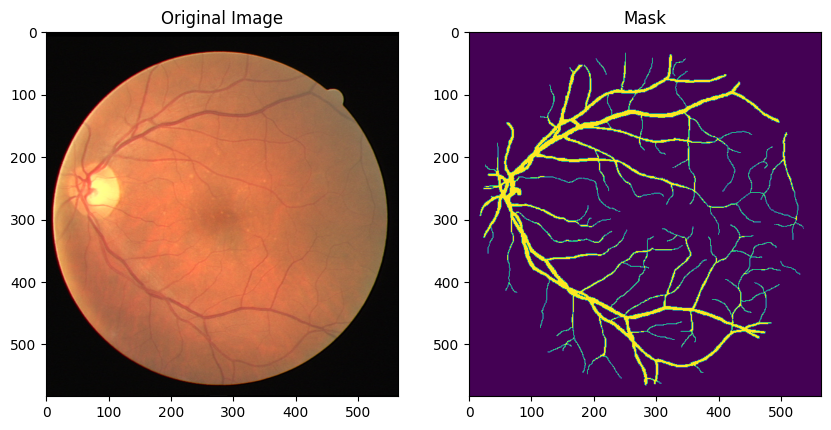

In [3]:
img=Image.open('/kaggle/input/sai-vessel-segmentation2/all/train/21_training.tif')
mask=Image.open('/kaggle/input/sai-vessel-segmentation2/all/train/21_manual1.gif')

print("Image Type:", type(img))
print("Mask Type:", type(mask))

print("Image Size:",img.size)

print("Image Shape:", np.array(img).shape, "Mask Shape:", np.array(mask).shape)

print("Unique in Mask:",np.unique(mask))
print("Image Data Type:", np.array(img).dtype)
print("Mask Data Type:", np.array(mask).dtype)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask")
plt.imshow(mask)
plt.show()

In [4]:
def reshape_to_512(imgpath):
    ori_image = Image.open(imgpath)
    reshaped_image=ori_image.resize((512,512),PIL.Image.NEAREST)
      
    return reshaped_image

After Reshape:
Image Type: <class 'PIL.Image.Image'>
Mask Type: <class 'PIL.Image.Image'>
Image Shape: (512, 512, 3) Mask Shape: (512, 512) Image dtype: uint8 Mask dtype: uint8
Unique in Mask: [  0 255]
Number of Ones in Mask: 19531.0


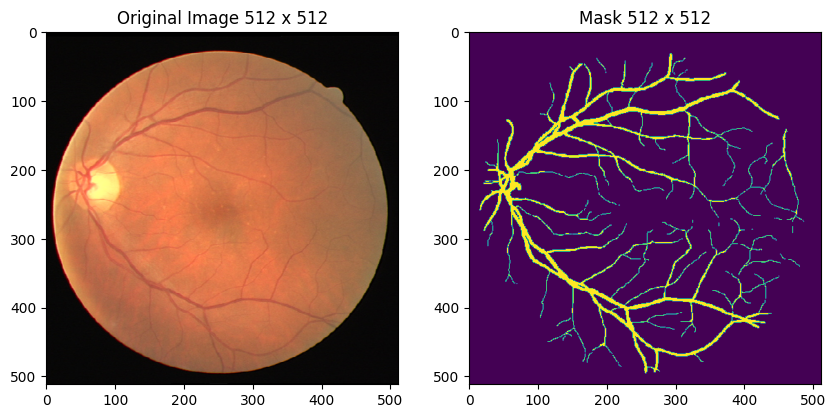

In [5]:
img=reshape_to_512("/kaggle/input/sai-vessel-segmentation2/all/train/21_training.tif")
mask=reshape_to_512("/kaggle/input/sai-vessel-segmentation2/all/train/21_manual1.gif")

print("After Reshape:")

print("Image Type:", type(img))
print("Mask Type:", type(mask))

print("Image Shape:",np.array(img).shape,"Mask Shape:",np.array(mask).shape,"Image dtype:",np.array(img).dtype,"Mask dtype:", np.array(mask).dtype)

print("Unique in Mask:",np.unique(mask))

print("Number of Ones in Mask:",np.sum(np.sum(np.array(mask)/255)))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512")
plt.imshow(img)
plt.subplot(1,2,2)
plt.title("Mask 512 x 512")
plt.imshow(mask)
plt.show()

In [6]:
class TrainDataset(Dataset):
    def __init__(self,path,transform=None):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=int(len(self.filepaths)/2)-4
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        idx=idx+21
        path=self.path + str(idx) + "_training.tif"
        img=reshape_to_512(path)
        img=self.transform(img)
        
        path=self.path + str(idx) + "_manual1.gif"
        mask=reshape_to_512(path)
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        mask[mask==255]=1
                      
        return img, mask

class ValDataset(Dataset):
    def __init__(self,path,transform=None):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=int(len(self.filepaths)/2)-16
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        idx=idx+37
        path=self.path + str(idx) + "_training.tif"
        img=reshape_to_512(path)
        img=self.transform(img)
        
        path=self.path + str(idx) + "_manual1.gif"
        mask=reshape_to_512(path)
        mask=np.array(mask)
        mask=torch.from_numpy(mask).type(torch.long)
        mask[mask==255]=1
                      
        return img, mask

In [7]:
train_dataset=TrainDataset("/kaggle/input/sai-vessel-segmentation2/all/train/")

#train_dataset,val_dataset=torch.utils.data.random_split(train_dataset,[16,4])

val_dataset=ValDataset("/kaggle/input/sai-vessel-segmentation2/all/train/")

batch_size=4

train_dataloader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

val_dataloader=DataLoader(dataset=val_dataset,batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Image dtype: torch.float32 Mask dtype: torch.int64
Unique in Mask: [0 1]


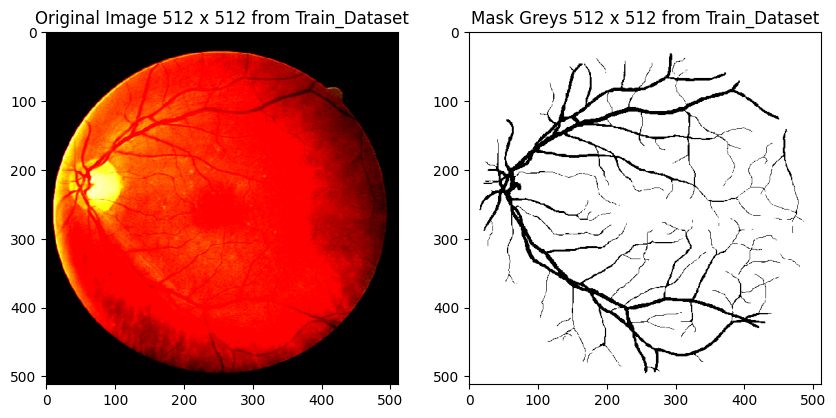

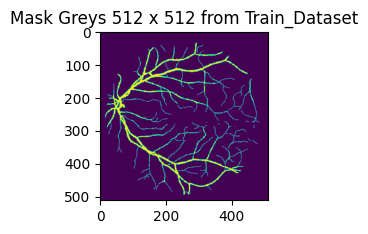

In [29]:
img,mask=train_dataset[0]

print("Image Shape:",img.shape,"Mask Shape:",mask.shape,"Image dtype:",img.dtype, "Mask dtype:", mask.dtype)
print("Unique in Mask:",np.unique(mask))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original Image 512 x 512 from Train_Dataset")
plt.imshow(torch.permute(img,(1,2,0)))

plt.subplot(1,2,2)
plt.title("Mask Greys 512 x 512 from Train_Dataset")
plt.imshow(mask,cmap='Greys')
plt.show()

plt.subplot(2,2,1)
plt.title("Mask Greys 512 x 512 from Train_Dataset")
plt.imshow(mask)
plt.show()

In [54]:
class Unet(nn.Module):
    def __init__(self, encoder, center, decoder):
        super().__init__()
        self.encoder=encoder
        self.center=center
        self.decoder=decoder
        #self.dropout=nn.Dropout(p=0.2, inplace=True)
    
    def forward(self,x):
        encoder_features_outputs=self.encoder(x)
#         print(len(encoder_features_outputs))
#         plt.plot(encoder_features_outputs[0])
        #self.dropout(encoder_features_outputs[-1])
        center_output=self.center(encoder_features_outputs[-1])
        logits=self.decoder(center_output, encoder_features_outputs)
        return logits

In [55]:
class Encoder(nn.Module):
    def __init__(self,pretrained_network):
        super().__init__()
        self.encoder=pretrained_network
    
    def forward(self,x):
        encoder_features_outputs=[]
        for layer in self.encoder.features:
                x=layer(x)
                encoder_features_outputs.append(x)
                        
        return encoder_features_outputs

In [56]:
class Center(nn.Sequential):
  def __init__(self):
        conv1=nn.Conv2d(in_channels=512,out_channels=1024, kernel_size=3,padding=1)
        bn1=nn.BatchNorm2d(num_features=1024)
        rl1=nn.ReLU()

        conv2=nn.Conv2d(in_channels=1024,out_channels=1024, kernel_size=3,padding=1)
        bn2=nn.BatchNorm2d(num_features=1024)
        rl2=nn.ReLU()
        
        super().__init__(conv1,bn1,rl1,conv2,bn2,rl2)

In [57]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
               
        self.rl=nn.ReLU()
                        
        self.conv5_up=nn.Conv2d(in_channels=1024,out_channels=512, kernel_size=3,padding=1)
        self.conv5_1=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1) # 1024 
        self.bn5_1=nn.BatchNorm2d(num_features=512)
        self.conv5_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_2=nn.BatchNorm2d(num_features=512)
        self.conv5_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn5_3=nn.BatchNorm2d(num_features=512)
        
        self.conv4_up=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.conv4_1=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_1=nn.BatchNorm2d(num_features=512)
        self.conv4_2=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_2=nn.BatchNorm2d(num_features=512)
        self.conv4_3=nn.Conv2d(in_channels=512,out_channels=512, kernel_size=3,padding=1)
        self.bn4_3=nn.BatchNorm2d(num_features=512)
        
        self.conv3_up=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.conv3_1=nn.Conv2d(in_channels=512,out_channels=256, kernel_size=3,padding=1)
        self.bn3_1=nn.BatchNorm2d(num_features=256)
        self.conv3_2=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_2=nn.BatchNorm2d(num_features=256)
        self.conv3_3=nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,padding=1)
        self.bn3_3=nn.BatchNorm2d(num_features=256)
        
        self.conv2_up=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.conv2_1=nn.Conv2d(in_channels=256,out_channels=128, kernel_size=3,padding=1)
        self.bn2_1=nn.BatchNorm2d(num_features=128)
        self.conv2_2=nn.Conv2d(in_channels=128,out_channels=128, kernel_size=3,padding=1)
        self.bn2_2=nn.BatchNorm2d(num_features=128)
        
        self.conv1_up=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.conv1_1=nn.Conv2d(in_channels=128,out_channels=64, kernel_size=3,padding=1)
        self.bn1_1=nn.BatchNorm2d(num_features=64)
        self.conv1_2=nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3,padding=1)
        self.bn1_2=nn.BatchNorm2d(num_features=64)
        
        self.convfinal=nn.Conv2d(in_channels=64,out_channels=2,kernel_size=1)
    
    def forward(self,x, encoder_features_output):
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv5_up(x)
        x=self.rl(x)
#         x=torch.cat((x,encoder_features_output[42]),dim=1)
        x=self.conv5_1(x)
        x=self.bn5_1(x)
        x=self.rl(x)
        x=self.conv5_2(x)
        x=self.bn5_2(x)
        x=self.rl(x)
        x=self.conv5_3(x)
        x=self.bn5_3(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv4_up(x)
        x=self.rl(x)
#         x=torch.cat((x,encoder_features_output[32]),dim=1)
        x=self.conv4_1(x)
        x=self.bn4_1(x)
        x=self.rl(x)
        x=self.conv4_2(x)
        x=self.bn4_2(x)
        x=self.rl(x)
        x=self.conv4_3(x)
        x=self.bn4_3(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv3_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[22]),dim=1)
        x=self.conv3_1(x)
        x=self.bn3_1(x)
        x=self.rl(x)
        x=self.conv3_2(x)
        x=self.bn3_2(x)
        x=self.rl(x)
        x=self.conv3_3(x)
        x=self.bn3_3(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv2_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[12]),dim=1)
        x=self.conv2_1(x)
        x=self.bn2_1(x)
        x=self.rl(x)
        x=self.conv2_2(x)
        x=self.bn2_2(x)
        x=self.rl(x)
        
        x=F.interpolate(x,scale_factor=2, mode="nearest")
        x=self.conv1_up(x)
        x=self.rl(x)
        x=torch.cat((x,encoder_features_output[5]),dim=1)
        x=self.conv1_1(x)
        x=self.bn1_1(x)
        x=self.rl(x)
        x=self.conv1_2(x)
        x=self.bn1_2(x)
        x=self.rl(x)
        
        logits=self.convfinal(x)
        
        return logits

In [58]:
def train_one_epoch(dataloader, model,loss_fn, optimizer):
    model.train()
    track_loss=0
    XintY=0
    X=0
    Y=0
    for i, (imgs, masks) in enumerate(dataloader):
        imgs=imgs.to(device)
        masks=masks.to(device)
        
        preds=model(imgs)
        
        loss=loss_fn(preds,masks)
        
        track_loss+=loss.item()
        
        predclass=torch.argmax(preds,dim=1)
        
        Y+=predclass.sum().item()
        X+=masks.sum().item()
        
        
        predclass[predclass==0]=2
        
        XintY+=(predclass==masks).type(torch.float).sum().item()
        
        print("Trainig Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss=round(track_loss/(i+1),2)
        running_dice_coef=round(((2*XintY)/(X+Y)),2)
        
        print("Training Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)
            
    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef    
    return epoch_loss, epoch_dice_coef


def val_one_epoch(dataloader, model,loss_fn):
    model.eval()
    track_loss=0
    XintY=0
    X=0
    Y=0
    with torch.no_grad():
        for i, (imgs, masks) in enumerate(dataloader):
            imgs=imgs.to(device)
            masks=masks.to(device)
            
            preds=model(imgs)
            
            loss=loss_fn(preds,masks)
            
            track_loss+=loss.item()
            
            predclass=torch.argmax(preds,dim=1)
            
            Y+=predclass.sum().item()
            X+=masks.sum().item()
            
            predclass[predclass==0]=2
            
            XintY+=(predclass==masks).type(torch.float).sum().item()
            
            print("Validation Batch",i+1,":","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)
            

            running_loss=round(track_loss/(i+1),2)
            running_dice_coef=round(((2*XintY)/(X+Y)),2)
            
            print("Validation Batch", i+1,":","/",len(dataloader), "Running Loss:",running_loss, "Running Dice_Coef:",running_dice_coef)
            
    epoch_loss=running_loss
    epoch_dice_coef=running_dice_coef
    return epoch_loss, epoch_dice_coef

In [59]:
pretrained_network=vgg16_bn(weights=VGG16_BN_Weights.DEFAULT)

for param in pretrained_network.features.parameters():
    param.requires_grad=False

encoder=Encoder(pretrained_network).to(device)
center=Center().to(device)
decoder=Decoder().to(device)

model=Unet(encoder,center, decoder).to(device)

loss_fn=nn.CrossEntropyLoss()
lr=0.001
optimizer=torch.optim.Adam(params=model.parameters(), lr=lr)
n_epochs=40

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dataloader,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")


for param in pretrained_network.features.parameters():
    param.requires_grad=True

n_epochs=40  
for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    val_epoch_loss, val_epoch_dice_coef=val_one_epoch(val_dataloader,model,loss_fn)
    print("Validation Epoch Loss:", val_epoch_loss, "Validation Epoch Dice_Coef:", val_epoch_dice_coef)
    print("--------------------------------------------------")


Epoch No: 1
Trainig Batch 1 : 2*XintY: 46620.0 X: 95062 Y: 412546 X+Y: 507608
Training Batch 1 : / 4 Running Loss: 0.68 Running Dice_Coef: 0.09
Trainig Batch 2 : 2*XintY: 168550.0 X: 185004 Y: 684252 X+Y: 869256
Training Batch 2 : / 4 Running Loss: 0.67 Running Dice_Coef: 0.19
Trainig Batch 3 : 2*XintY: 283628.0 X: 269633 Y: 865027 X+Y: 1134660
Training Batch 3 : / 4 Running Loss: 0.63 Running Dice_Coef: 0.25
Trainig Batch 4 : 2*XintY: 395400.0 X: 364581 Y: 1036707 X+Y: 1401288
Training Batch 4 : / 4 Running Loss: 0.6 Running Dice_Coef: 0.28
Training Epoch Loss: 0.6 Training Epoch Dice_Coef: 0.28
Validation Batch 1 : 2*XintY: 175026.0 X: 88013 Y: 747307 X+Y: 835320
Validation Batch 1 : / 1 Running Loss: 4.71 Running Dice_Coef: 0.21
Validation Epoch Loss: 4.71 Validation Epoch Dice_Coef: 0.21
--------------------------------------------------
Epoch No: 2
Trainig Batch 1 : 2*XintY: 110232.0 X: 89482 Y: 117605 X+Y: 207087
Training Batch 1 : / 4 Running Loss: 0.45 Running Dice_Coef: 0.53
T

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


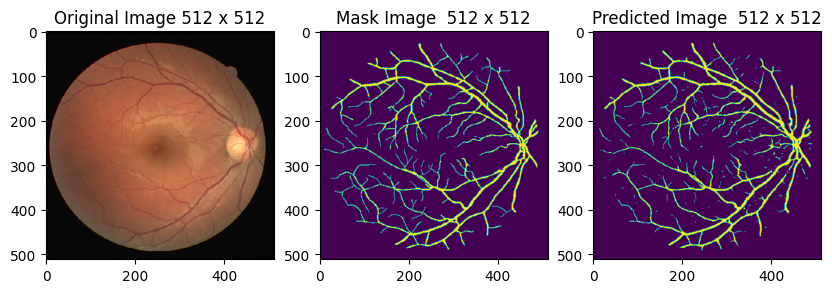

In [61]:
plotres(imgs[0],predclass[0],masks[0])

In [ ]:
def plotres(img,pred,mask=None):
    img[0,:,:]=img[0,:,:]*0.229 + 0.485
    img[1,:,:]=img[1,:,:]*0.224 + 0.456
    img[2,:,:]=img[2,:,:]*0.225 + 0.406
    if mask!=None:
        print("Image Shape:",img.shape,"Mask Shape:", mask.shape, "Pred Shape:",pred.shape, "Image dtype", img.dtype, "Mask dtype",mask.dtype, "Pred dtype",pred.dtype)
        print("Mask Unique:",mask.unique())
    else:
        print("Image Shape:",img.shape, "Pred Shape:", pred.shape, "Image dtype:",img.dtype, "Pred dtype:",pred.dtype)
    
    print("Pred Unique:",pred.unique())
    
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,3,1)
    plt.title("Original Image 512 x 512")
    plt.imshow(torch.permute(img.cpu(),(1,2,0)))
    
    if mask!=None:
        plt.subplot(1,3,2)
        plt.title("Mask Image  512 x 512")
        plt.imshow(mask.cpu())
    
    plt.subplot(1,3,3)
    plt.title("Predicted Image  512 x 512")
    plt.imshow(pred.cpu())
    plt.show()

In [ ]:
imgs,masks=next(iter(val_dataloader))
model.eval()

imgs=imgs.to(device)
masks=masks.to(device)

with torch.no_grad():
    preds=model(imgs)
    print(preds)

On Validation Set: 2*XintY: 148064.0 X: 88013 Y: 94347 X+Y: 182360
Validation Dice Coef: 0.81
Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


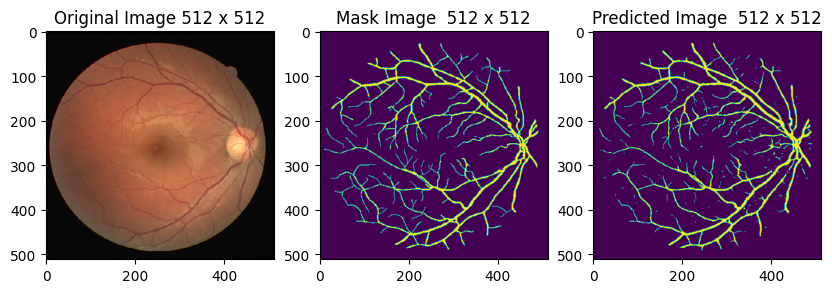

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


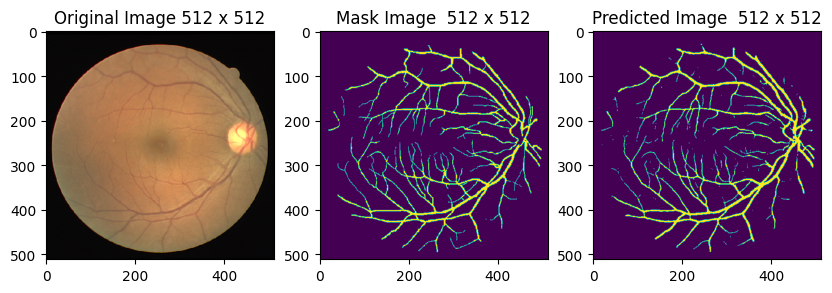

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


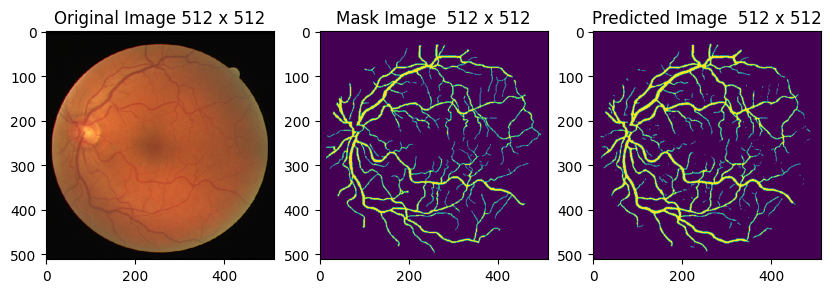

Image Shape: torch.Size([3, 512, 512]) Mask Shape: torch.Size([512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype torch.float32 Mask dtype torch.int64 Pred dtype torch.int64
Mask Unique: tensor([0, 1], device='cuda:0')
Pred Unique: tensor([0, 1], device='cuda:0')


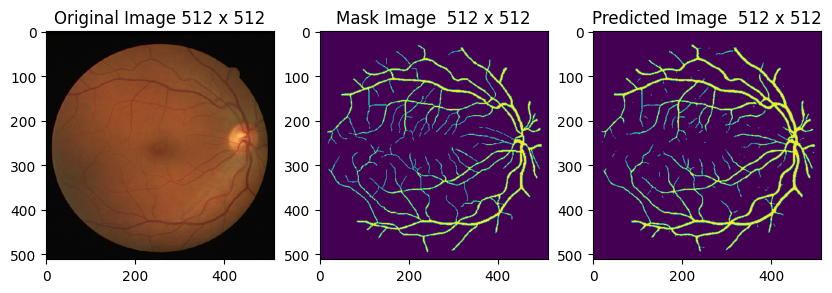

In [16]:
imgs,masks=next(iter(val_dataloader))
model.eval()

imgs=imgs.to(device)
masks=masks.to(device)

with torch.no_grad():
    preds=model(imgs)
    
    predclass=torch.argmax(preds,dim=1)
            
    Y=predclass.sum().item()
    X=masks.sum().item()
            
    predclass[predclass==0]=2
    
    XintY=(predclass==masks).type(torch.float).sum().item()
    
    print("On Validation Set:","2*XintY:",2*XintY,"X:",X,"Y:",Y, "X+Y:",X+Y)
    
    dice_coef=round((2*XintY)/(X+Y),2)
    
    
print("Validation Dice Coef:",dice_coef)

predclass[predclass==2]=0
plotres(imgs[0],predclass[0],masks[0])
plotres(imgs[1],predclass[1],masks[1])
plotres(imgs[2],predclass[2],masks[2])
plotres(imgs[3],predclass[3],masks[3])

In [17]:
train_dataset=TrainDataset("/kaggle/input/sai-vessel-segmentation2/all/train/", "yes")

batch_size=4

n_epochs=40

train_dataloader=DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)

for i in range(n_epochs):
    print("Epoch No:",i+1)
    train_epoch_loss, train_epoch_dice_coef=train_one_epoch(train_dataloader,model,loss_fn,optimizer)
    print("Training Epoch Loss:", train_epoch_loss, "Training Epoch Dice_Coef:", train_epoch_dice_coef)
    print("--------------------------------------------------")

Epoch No: 1
Trainig Batch 1 : 2*XintY: 145548.0 X: 88775 Y: 83921 X+Y: 172696
Training Batch 1 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.84
Trainig Batch 2 : 2*XintY: 276972.0 X: 165756 Y: 160526 X+Y: 326282
Training Batch 2 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.85
Trainig Batch 3 : 2*XintY: 429486.0 X: 264755 Y: 244592 X+Y: 509347
Training Batch 3 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.84
Trainig Batch 4 : 2*XintY: 590020.0 X: 364581 Y: 335548 X+Y: 700129
Training Batch 4 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.84
Training Epoch Loss: 0.06 Training Epoch Dice_Coef: 0.84
--------------------------------------------------
Epoch No: 2
Trainig Batch 1 : 2*XintY: 166198.0 X: 97760 Y: 96545 X+Y: 194305
Training Batch 1 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.86
Trainig Batch 2 : 2*XintY: 310934.0 X: 181363 Y: 184174 X+Y: 365537
Training Batch 2 : / 4 Running Loss: 0.06 Running Dice_Coef: 0.85
Trainig Batch 3 : 2*XintY: 469922.0 X: 277141 Y: 274018 X+Y: 551159


In [18]:
class TestDataset(Dataset):
    def __init__(self,path):
        super().__init__()
        self.path=path
        _,_,self.filepaths=next(os.walk(path))
        self.length=len(self.filepaths)
        self.transform=Compose([ToTensor(), Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        idx=idx+1
        if idx <= 9:
            path=self.path + "0" + str(idx) + "_test.tif"
        else:
            path=self.path + str(idx) + "_test.tif"
        
        img=reshape_to_512(path)
        img=self.transform(img)
        
        return img
    

In [31]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [20]:
test_dataset=TestDataset("/kaggle/input/sai-vessel-segmentation2/all/test/")

batch_size=2
test_dataloader=DataLoader(dataset=test_dataset,batch_size=batch_size)

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


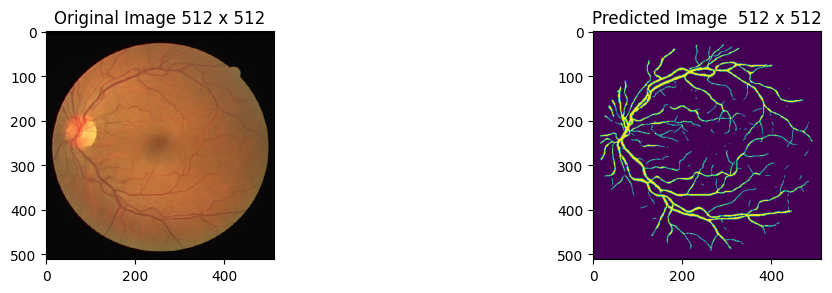

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


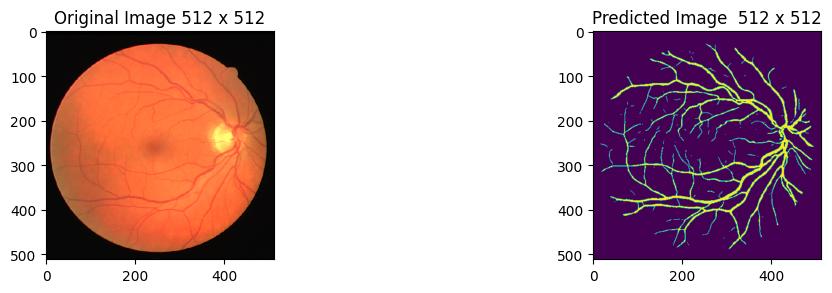

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


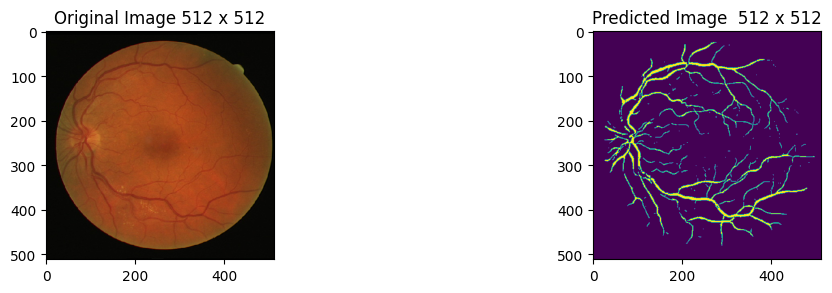

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


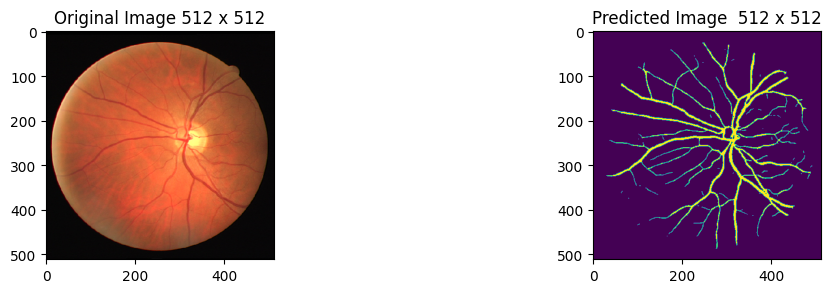

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


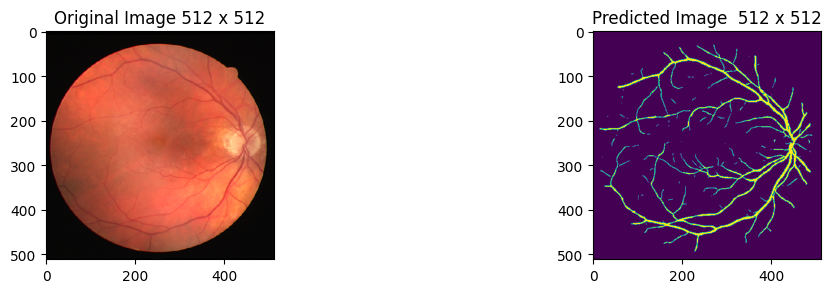

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


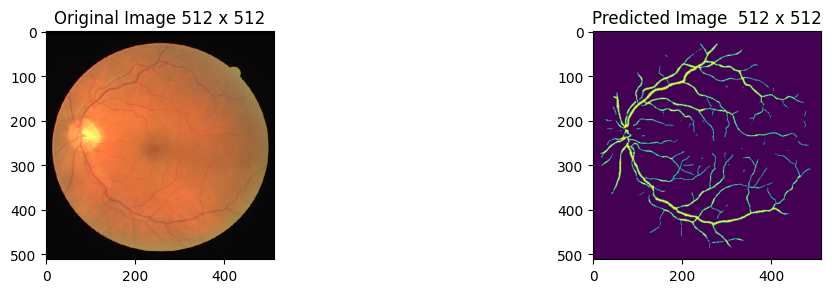

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


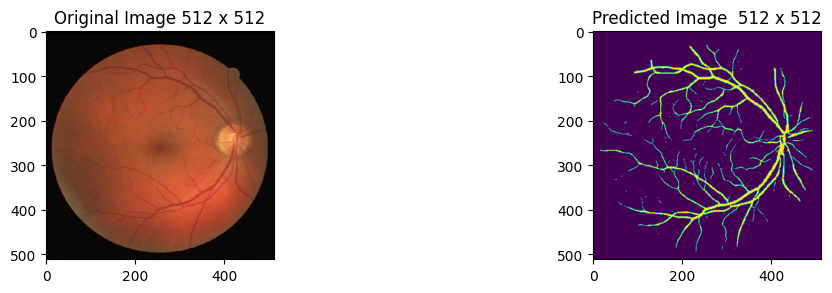

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


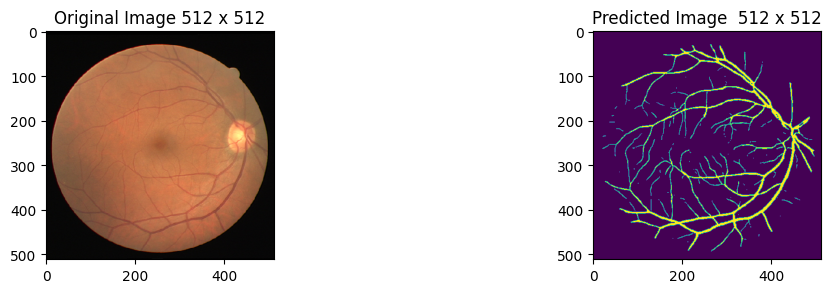

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


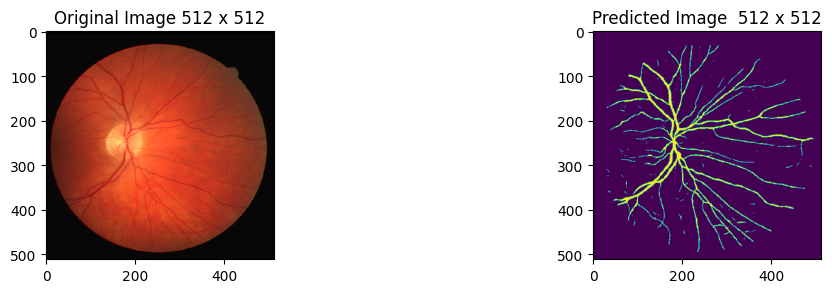

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


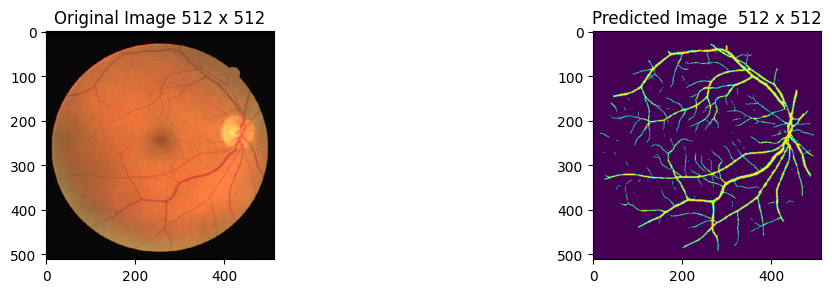

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


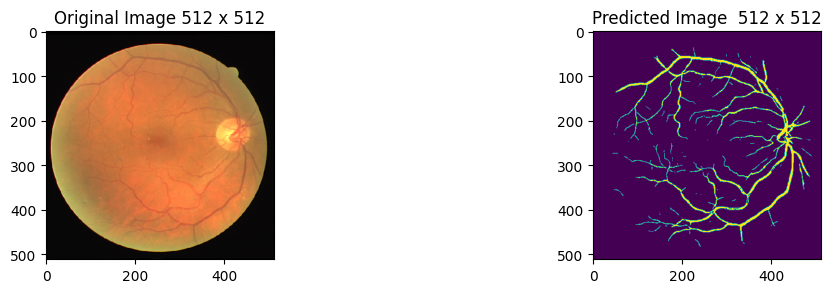

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


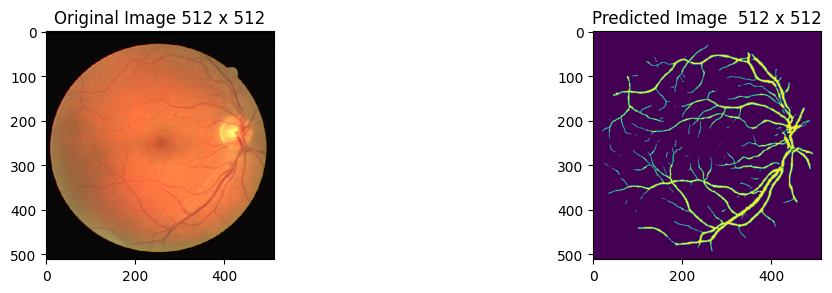

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


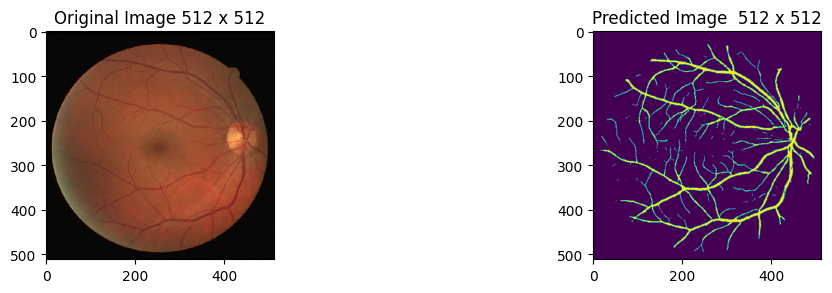

Image Shape: torch.Size([3, 512, 512]) Pred Shape: torch.Size([512, 512]) Image dtype: torch.float32 Pred dtype: torch.int64
Pred Unique: tensor([0, 1])


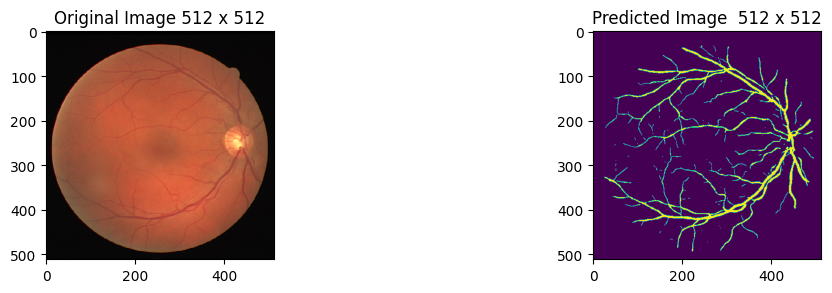

Id                                          Predicted
0    0  15652 3 16106 1 16164 3 16616 3 16675 3 17128 ...
1    1  15102 3 15616 3 16130 3 16147 1 16642 6 16659 ...
2    2  13070 8 13578 8 14089 7 14601 5 15112 3 15566 ...
3    3  13559 4 14071 5 14585 3 15098 3 15610 4 16122 ...
4    4  16132 1 16642 4 17153 3 17188 4 17664 3 17699 ...
5    5  17187 4 17699 6 18213 6 18629 3 18726 6 19141 ...
6    6  16143 2 16656 2 17130 3 17168 2 17643 3 17680 ...
7    7  15591 5 16105 4 16146 3 16618 4 16657 4 17130 ...
8    8  15090 2 15125 4 15602 3 15637 4 16115 3 16148 ...
9    9  16128 2 16640 2 17113 2 17152 3 17625 4 17665 ...
10  10  16607 5 17114 9 17616 17 18123 20 18631 18 186...
11  11  15080 3 15591 5 15640 2 16103 5 16152 2 16615 ...
12  12  15624 3 16136 3 16607 3 16649 3 17120 3 17161 ...
13  13  13083 2 13595 3 14107 3 14619 3 15059 1 15131 ...
14  14  16136 1 16606 2 16648 1 16666 2 17106 1 17118 ...
15  15  15112 4 15625 5 16138 6 16652 6 16684 2 17166 ...
16  16  19170 1 19682 1 20194 1 20658 1 20706 1 21169 ...
17  17  16641 2 17152 3 17664 2 18175 2 18685 3 19196 ...
18  18  15106 1 15618 2 16130 3 16643 3 17155 3 17196 ...
19  19  16629 1 17140 2 17168 1 17652 2 17680 1 18161 ...

In [21]:
def eval_one_epoch(dataloader, model):
    model.eval()
    outputs=[]
    for i, imgs in enumerate(dataloader):
        imgs=imgs.to(device)
        preds=model(imgs)
               
        with torch.no_grad():
            for i in range(preds.shape[0]):
                pred=preds[i,:,:,:]
                pred=torch.argmax(pred,dim=0).cpu()
                
                plotres(imgs[i],pred)
                
                predf=pred.flatten()
                
                pixelidx=np.where(predf==1)[0]+1
                
                run_lengths=[]
                
                for pxid in pixelidx:
                    if len(run_lengths)==0:
                        run_lengths.extend((pxid,1))
                    elif pxid>prev+1:
                        run_lengths.extend((pxid,1))
                    else:
                        run_lengths[-1]+=1
                    prev=pxid
                
                output = ' '.join([str(r) for r in run_lengths])
                
                outputs.append(output)
    return outputs

outputs=eval_one_epoch(test_dataloader,model)
df=pd.DataFrame(columns=['Id','Predicted'])   
df['Id']=[str(i) for i in range(20)]
df['Predicted']=outputs
df.to_csv("submission.csv", index=None)
df